## RESNET ARCHITECTURE

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow
import tensorflow as tf
print(tf.__version__)

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

2.6.0


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split = 0.2)
train_data=train.flow_from_directory(directory = 'DATASET/TRAIN',target_size=(224,224),
                                     batch_size=32,class_mode='categorical')

Found 1495 images belonging to 20 classes.


In [4]:
test=ImageDataGenerator(rescale=1./255)
test_data=test.flow_from_directory(directory = 'DATASET/TEST',target_size=(224,224),
                                   batch_size=32,class_mode='categorical')

Found 1495 images belonging to 20 classes.


In [5]:
def resnet(input_shape, n_classes):
  
  def conv_bn_rl(x, f, k=1, s=1, p='same'):
    x = Conv2D(f, k, strides=s, padding=p)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
  
  
  def identity_block(tensor, f):
    x = conv_bn_rl(tensor, f)
    x = conv_bn_rl(x, f, 3)
    x = Conv2D(4*f, 1)(x)
    x = BatchNormalization()(x)
    
    x = Add()([x, tensor])
    output = ReLU()(x)
    return output
  
  
  def conv_block(tensor, f, s):
    x = conv_bn_rl(tensor, f)
    x = conv_bn_rl(x, f, 3, s)
    x = Conv2D(4*f, 1)(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv2D(4*f, 1, strides=s)(tensor)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    output = ReLU()(x)
    return output
  
  
  def resnet_block(x, f, r, s=2):
    x = conv_block(x, f, s)
    for _ in range(r-1):
      x = identity_block(x, f)
    return x
    
  
  input = Input(input_shape)
  
  x = conv_bn_rl(input, 64, 7, 2)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = resnet_block(x, 64, 3, 1)
  x = resnet_block(x, 128, 4)
  x = resnet_block(x, 256, 6)
  x = resnet_block(x, 512, 3)
  
  x = GlobalAvgPool2D()(x)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy',tensorflow.keras.metrics.Precision()])
  return model
     

input_shape = 224, 224, 3
n_classes = 20

K.clear_session()
model = resnet(input_shape, n_classes)
model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
model_path = "MOBILENET.h5"

from keras.callbacks import ModelCheckpoint

M = ModelCheckpoint(model_path, monitor='accuracy', verbose=1, save_best_only=True)

In [7]:
epochs = 100
batch_size = 512

In [8]:
#### Fitting the model
history = model.fit(
           train_data, steps_per_epoch=train_data.samples // batch_size, 
           epochs=epochs, 
           validation_data=test_data,validation_steps=test_data.samples // batch_size,
           callbacks=[M])

Epoch 1/100
2/2 [==============================] - 44s 27s/step - loss: 7.3865 - accuracy: 0.1091 - precision: 0.1212 - val_loss: 3.0796 - val_accuracy: 0.0156 - val_precision: 0.0000e+00

Epoch 00001: accuracy improved from -inf to 0.10909, saving model to MOBILENET.h5
Epoch 2/100
2/2 [==============================] - 39s 23s/step - loss: 5.7305 - accuracy: 0.0781 - precision: 0.1000 - val_loss: 3.1867 - val_accuracy: 0.0469 - val_precision: 0.2500

Epoch 00002: accuracy did not improve from 0.10909
Epoch 3/100
2/2 [==============================] - 40s 23s/step - loss: 4.0263 - accuracy: 0.1719 - precision: 0.2857 - val_loss: 3.8923 - val_accuracy: 0.0781 - val_precision: 0.0000e+00

Epoch 00003: accuracy improved from 0.10909 to 0.17188, saving model to MOBILENET.h5
Epoch 4/100
2/2 [==============================] - 39s 23s/step - loss: 3.9630 - accuracy: 0.0781 - precision: 0.0000e+00 - val_loss: 4.7019 - val_accuracy: 0.0625 - val_precision: 0.0000e+00

Epoch 00004: accuracy did 

2/2 [==============================] - 39s 22s/step - loss: 2.5419 - accuracy: 0.3594 - precision: 0.5714 - val_loss: 3.7222 - val_accuracy: 0.0156 - val_precision: 0.0000e+00

Epoch 00034: accuracy did not improve from 0.37500
Epoch 35/100
2/2 [==============================] - 39s 23s/step - loss: 2.5010 - accuracy: 0.2969 - precision: 0.7778 - val_loss: 3.6021 - val_accuracy: 0.0156 - val_precision: 0.0000e+00

Epoch 00035: accuracy did not improve from 0.37500
Epoch 36/100
2/2 [==============================] - 39s 23s/step - loss: 2.4119 - accuracy: 0.1875 - precision: 0.5556 - val_loss: 3.6725 - val_accuracy: 0.0156 - val_precision: 0.0000e+00

Epoch 00036: accuracy did not improve from 0.37500
Epoch 37/100
2/2 [==============================] - 38s 22s/step - loss: 2.2199 - accuracy: 0.2969 - precision: 0.5000 - val_loss: 3.9135 - val_accuracy: 0.0469 - val_precision: 0.0000e+00

Epoch 00037: accuracy did not improve from 0.37500
Epoch 38/100
2/2 [==============================]


Epoch 00067: accuracy did not improve from 0.45312
Epoch 68/100
2/2 [==============================] - 39s 23s/step - loss: 1.7452 - accuracy: 0.3906 - precision: 0.6111 - val_loss: 4.2604 - val_accuracy: 0.0469 - val_precision: 0.0000e+00

Epoch 00068: accuracy did not improve from 0.45312
Epoch 69/100
2/2 [==============================] - 39s 22s/step - loss: 2.3667 - accuracy: 0.4219 - precision: 0.6087 - val_loss: 5.0429 - val_accuracy: 0.0156 - val_precision: 0.0000e+00

Epoch 00069: accuracy did not improve from 0.45312
Epoch 70/100
2/2 [==============================] - 40s 23s/step - loss: 2.4020 - accuracy: 0.3438 - precision: 0.5000 - val_loss: 4.0179 - val_accuracy: 0.0469 - val_precision: 0.0000e+00

Epoch 00070: accuracy did not improve from 0.45312
Epoch 71/100
2/2 [==============================] - 39s 22s/step - loss: 2.5935 - accuracy: 0.2656 - precision: 0.4444 - val_loss: 4.1124 - val_accuracy: 0.0938 - val_precision: 0.0000e+00

Epoch 00071: accuracy did not impro

In [9]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'val_loss', 'val_accuracy', 'val_precision'])

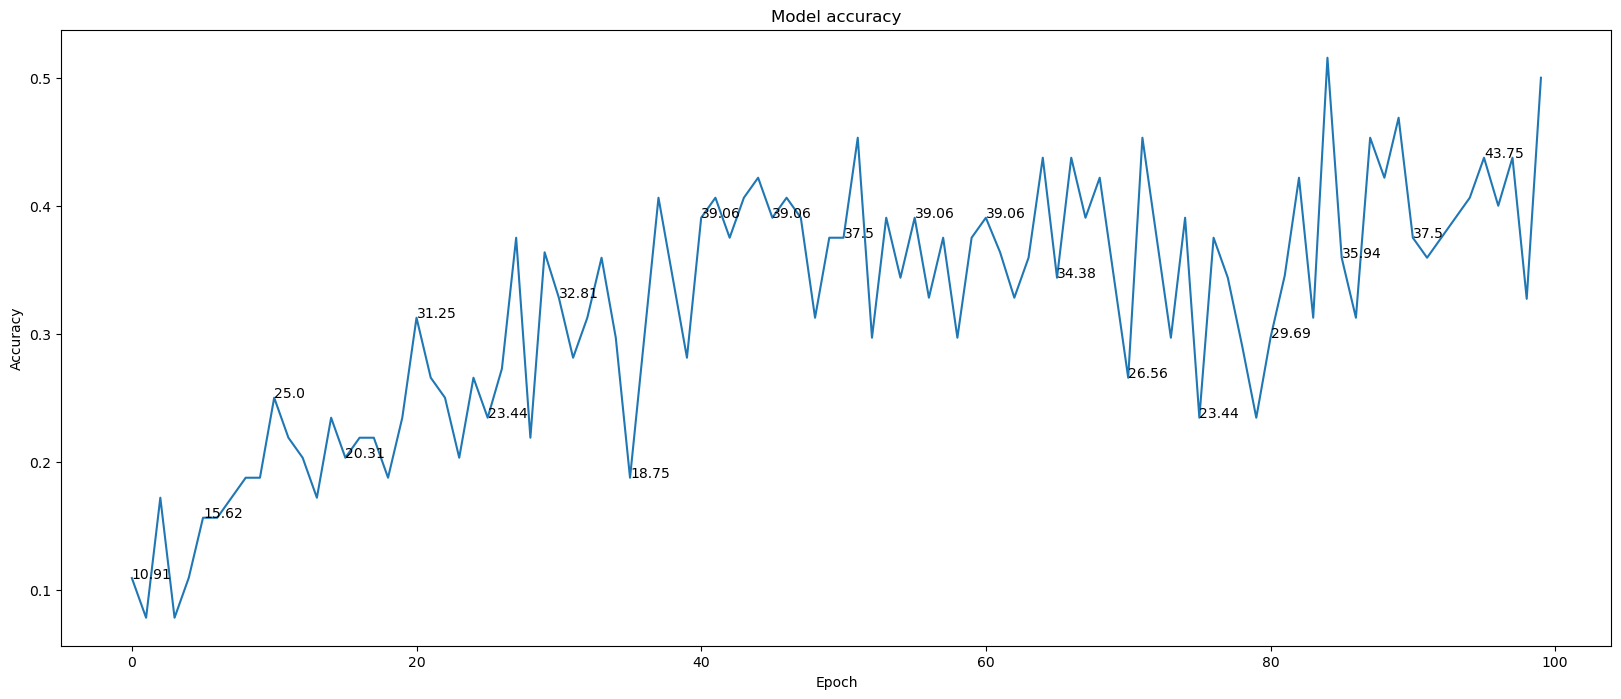

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['accuracy'][i]*100,2),xy=(i,history.history['accuracy'][i]))

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

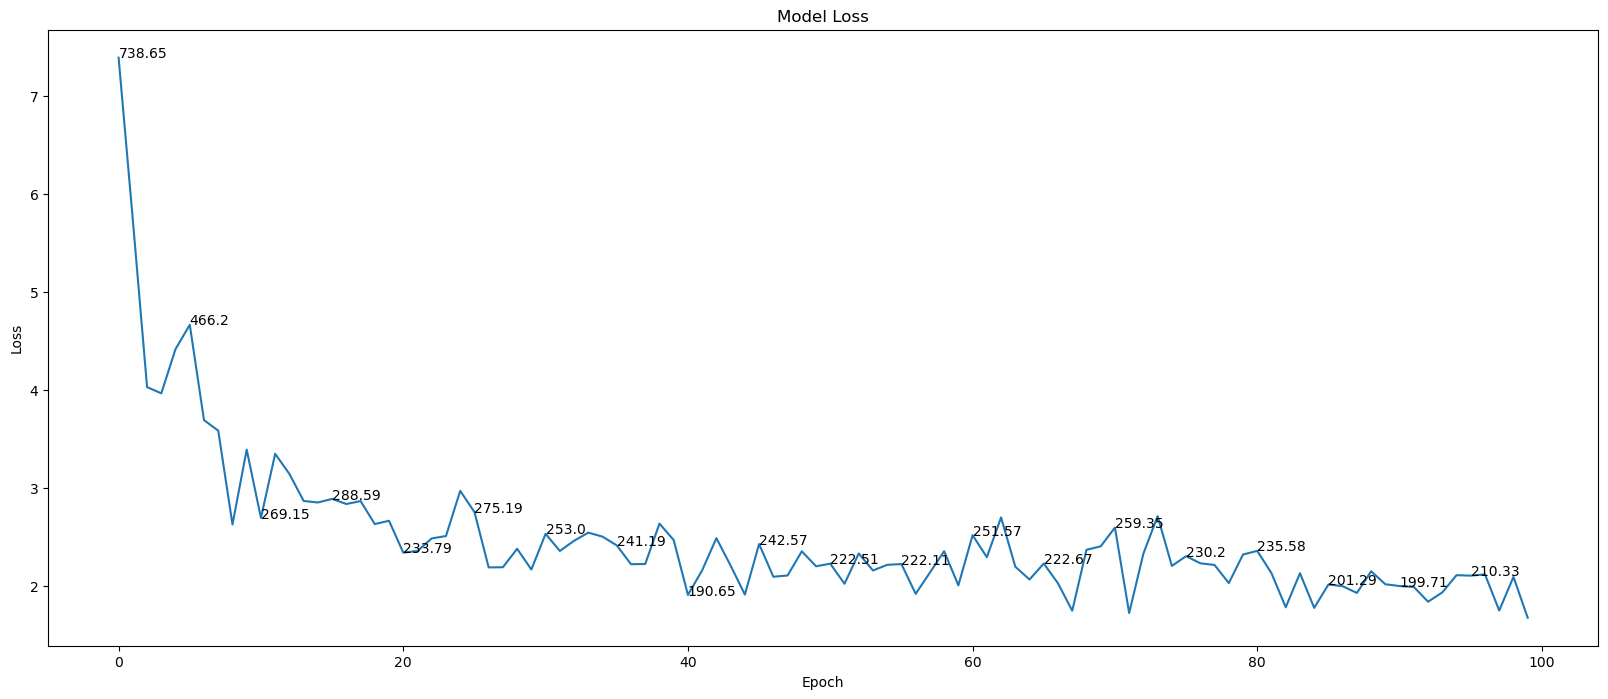

In [11]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['loss'][i]*100,2),xy=(i,history.history['loss'][i]))

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()